<font color='blue'> **44_ex-gwt-mt3dms-p08** </font> 
<font color='red'> **_______________________________  _______________________________** </font> 

In [1]:
import os ; from pathlib import Path ; from pprint import pformat ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.utils.util_array import read1d
from modflow_devtools.misc import get_env ;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
_R = Path("_R")   ; _R.mkdir(exist_ok=True); DA = Path('_R/44_ex-gwt-mt3dms-p08'); DA.mkdir(exist_ok=True)   ; from flopy.plot.styles import styles ; import pandas as pd 
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MT3D') ; sim_name = '44_ex-gwt-mt3dms-p08'

In [2]:
nlay=27;nrow=1;ncol=50                                      ;delr=5.0;delc=1.0;delz=0.25                               ; nouter,ninner=100,300;hclose,rclose,relax=1e-6,1e-6,1.0;percel=1.0
k1 = 5e-4 / 100.0 * 86400  ;  k2 = 1e-2 / 100.0 * 86400    ; k11 = k1 * np.ones((nlay, nrow, ncol), dtype=float)       ; k11[11:19,:,0:24]=k2                         ; k11[11:19,:,36:]=k2  
laytyp = 6 * [1] + 21 * [0]  ; rech = 10/100/365           ; trpt= 0.01; trpv=0.01   ; dmcoef = 1.34e-5/100/100*86400  ; al=0.5 ; ath1 =al*trpt ;atv=al*trpv          # |dmcoef|cm^2/s->m^2/d  
strt   = np.empty((nlay * ncol), dtype=float)              ; ff = open(REF1/'p08shead.dat')    ; strt = read1d(ff, strt).reshape((nlay, nrow, ncol))                  ; ff.close()
ibound = np.ones((nlay, nrow, ncol), dtype=int)            ; ibound[5:, :, -1] = -1            ; ibound[strt < 0] = 0                                                 ; idomain = 1

prsity=0.35 ; sconc=0.0   ; top=6.75   ;botm=[top-delz*k for k in range(1,nlay+1)]   ;k33=k11  ; icelltype=6*[1]+21*[0]        ;mixelm = -1  ;length_units="meters";time_units="days" 

chdspd = []
for k in np.arange(nlay):
    if strt[k, 0, -1] != -999:       chdspd.append([(k, 0, ncol - 1), strt[k, 0, -1], 0])
CHD = {0: chdspd}                                                  

cncspd_1 = [] ; cncspd_2 = []        ; cnc_1 = 1  ; cnc_2 = 0  
for col in np.arange(8, 16):           cncspd_1.append([(0, 0, col), cnc_1])    ; cncspd_2.append([(0, 0, col), cnc_2])  ; CNC = {0: cncspd_1, 1: cncspd_2}                                   

perlen = [5 * 365, 15 * 365]    ; nper = len(perlen) ; nstp = [365, 1095] ; tsmult = [1.0, 1.0]     
tdis_rc = []
for i in range(nper):   tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
REC=[("CONCENTRATION","LAST"),("CONCENTRATION","STEPS","73","146","219","292","365","438","511","584","657","730","803","876","949","1022","1095","1168","1241","1314","1387","1460",),
     ("BUDGET","LAST"),]        ; CAN = [("COLUMNS",10,"WIDTH",15,"DIGITS",6,"GENERAL")]

In [3]:
def build_models(mixelm=0, silent=False):
    global sim ,gwf, gwt , npf , DB
    name = "p08"    ;gwfname="gwf-"+name ;gwtname="gwt-"+name   ; DB = os.path.join(DA/name)    ; sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=DB)
    
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)     
    gwf    = flopy.mf6.ModflowGwf(sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="dbd",linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,under_relaxation_kappa=0.08,under_relaxation_gamma=0.05,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
            backtracking_reduction_factor=0.2,backtracking_residual_limit=5.0e-4,inner_dvclose=hclose,rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
            number_orthogonalizations=2,preconditioner_levels=8,preconditioner_drop_tolerance=0.001,filename=f"{gwfname}.ims")             ; sim.register_ims_package(imsgwf, [gwf.name])          
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwfname}.dis",)
    npf = flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k11,save_specific_discharge=True,filename=f"{gwfname}.npf")
    sto = flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0)                                                   ; flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")     
    flopy.mf6.ModflowGwfchd(gwf,maxbound=len(CHD),   stress_period_data=CHD,  save_flows=False,auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfrcha(gwf,print_flows=True,recharge=rech,pname="RCH-1",filename=f"{gwfname}.rch") ; SA=[("HEAD", "LAST"), ("BUDGET", "LAST")]
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",headprintrecord=CAN,saverecord=SA,printrecord=SA)
    
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")         ; gwt.name_file.save_flows = True  ; FI = f"{gwtname}.ic"
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="dbd",linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,under_relaxation_kappa =0.08  ,under_relaxation_gamma =0.05 ,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
            backtracking_reduction_factor=0.2,backtracking_residual_limit  =5.0e-4,inner_dvclose=hclose   ,rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
            number_orthogonalizations=2  ,preconditioner_levels=8,preconditioner_drop_tolerance=0.001  ,filename=f"{gwtname}.ims")              ; sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwtname}.dis")  ; flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=FI)
    if mixelm >= 0:     scheme = "UPSTREAM"
    elif mixelm == -1:  scheme = "TVD"
    else:               raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:            flopy.mf6.ModflowGwtdsp(gwt,alh=al,ath1=ath1,atv=atv,filename=f"{gwtname}.dsp")
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,bulk_density=None,distcoef=None,filename=f"{gwtname}.mst") 
    flopy.mf6.ModflowGwtssm(gwt, sources=[("CHD-1", "AUX", "CONCENTRATION")], filename=f"{gwtname}.ssm")  ; PRINT = [("CONCENTRATION", "LAST"), ("BUDGET", "LAST")]
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",concentrationprintrecord=CAN,saverecord=REC ,printrecord=PRINT)
    flopy.mf6.ModflowGwtcnc(gwt,print_flows=True,stress_period_data=CNC,pname="CNC-1",filename=f"{gwtname}.cnc")   
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")      ; return sim

def write_models(sim, silent=True):  sim.write_simulation(silent=silent)
def run_models(sim, silent=True):    success, buff = sim.run_simulation(silent=silent, report=True)                              ; assert success, pformat(buff)

def scenario(idx, silent=True): 
    sim = build_models(mixelm=mixelm)
    if write:       write_models(sim, silent=silent)
    if run:         run_models(sim, silent=silent)              
scenario(0, silent=True)    # 26'' 

In [4]:
DC = list(os.listdir(DA)) # print(list(os.listdir(DA)))
F3 = os.path.join(DA/DC[0]/'gwf-p08.hds') ;hdobj=flopy.utils.HeadFile(F3)                    ; HH=hdobj.get_data()                  ; TI=hdobj.get_times()
sim.set_sim_path(os.path.join(DA/DC[0]))  ; gwt = sim.get_model(list(sim.model_names)[1])    ; ucnobj = gwt.output.concentration()  ; CC = ucnobj.get_alldata() 

In [5]:
pd.DataFrame(HH.reshape(-1)).describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
0,1350.0,-6.444444e+28,2.456340e+29,-1.000000e+30,5.551526,6.488769,6.636193,6.665521


In [6]:
pd.DataFrame(CC.reshape(-1)).describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
0,27000.0,-6.444444e+28,2.455475e+29,-1.000000e+30,3.107694e-26,3.399209e-08,0.005286,1.0


In [25]:
S = .05      ; print(HH.max(), HH.min(),'_____',np.quantile(HH, S))  ; LH=np.arange(0,np.quantile(HH, S),np.quantile(HH, S)/5)  ; LH= np.flip(LH) ;
S = .6      ; print(CC.max(), CC.min(),'_____',np.quantile(CC, S))  ; LC=np.arange(np.quantile(CC, S),CC.max(),CC.max()/5) 

SEL=[7,11,19] ;CL=np.arange(0.05,CC.max()/2,CC.max()/10)                  ; MG=gwf.npf.k.array       ;RR={'Row':0};MV=[MG[0,0,0]]

6.66552096913561 -1e+30 _____ -1e+30
1.0 -1e+30 _____ 2.2396082186063545e-05


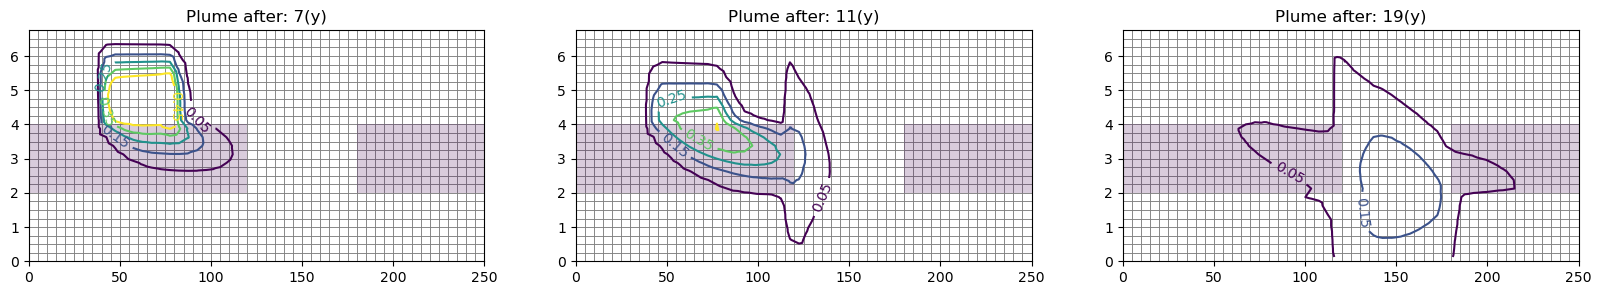

In [26]:
fig = plt.figure(figsize=(20, 3))  
A=0; ax = fig.add_subplot(131)     ; ma=flopy.plot.PlotCrossSection(model=gwf,line=RR) ; ma.plot_grid(lw=0.5)          ; ma.plot_ibound() ; plt.title("Plume after: "+str(SEL[A]) + "(y)") 
cs = ma.contour_array(CC[SEL[A]], levels=CL)                                      ; plt.clabel(cs, fmt=r"%4.2f")  ; VK=ma.plot_array(MG, masked_values=MV, alpha=0.2)

cv = ma.contour_array(HH, colors='black',levels=LH);plt.clabel(cv, fmt=r"%4.2f")

B=1; ax = fig.add_subplot(132) ; ma=flopy.plot.PlotCrossSection(model=gwf,line=RR)     ; ma.plot_grid(lw=0.5)          ; ma.plot_ibound() ; plt.title("Plume after: "+str(SEL[B]) + "(y)") 
cs = ma.contour_array(CC[SEL[B]], levels=CL)                                      ; plt.clabel(cs, fmt=r"%4.2f")  ; VK=ma.plot_array(MG, masked_values=MV, alpha=0.2)
C=2; ax = fig.add_subplot(133) ; ma=flopy.plot.PlotCrossSection(model=gwf,line=RR)     ; ma.plot_grid(lw=0.5)          ; ma.plot_ibound() ; plt.title("Plume after: "+str(SEL[C]) + "(y)") 
cs = ma.contour_array(CC[SEL[C]], levels=CL)                                      ; plt.clabel(cs, fmt=r"%4.2f")  ; VK=ma.plot_array(MG, masked_values=MV, alpha=0.2) ; plt.show()

In [8]:
DB = Path(DB)  
pd.DataFrame(tdis_rc).to_csv(DB/"01_tdis_rc.csv")
with open(DB/'02_temp_08.csv', "w") as file:
    for item in TI: file.write("%s\n" % item)
with open(DB/'03_REC.csv', "w") as file:
    for item in REC[1]: file.write("%s\n" % item)